In [ ]:
"results_visual/n_seller_10_n_adv_1_strength_1.0/market_log.json"

Matplotlib is building the font cache; this may take a moment.


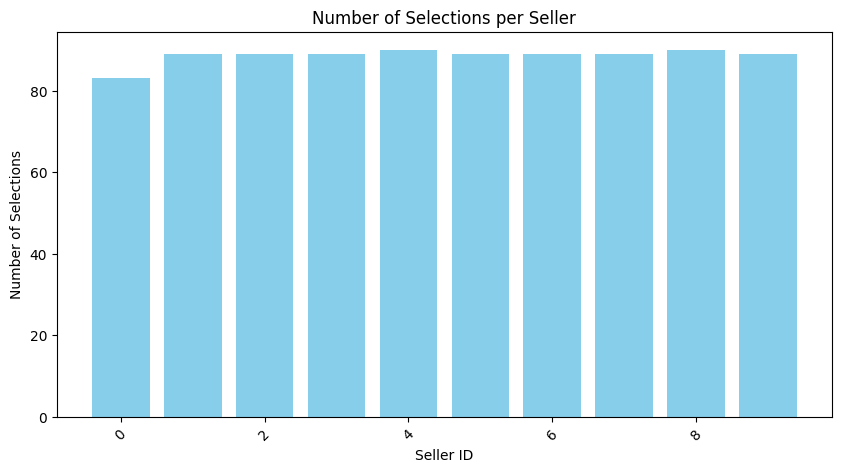

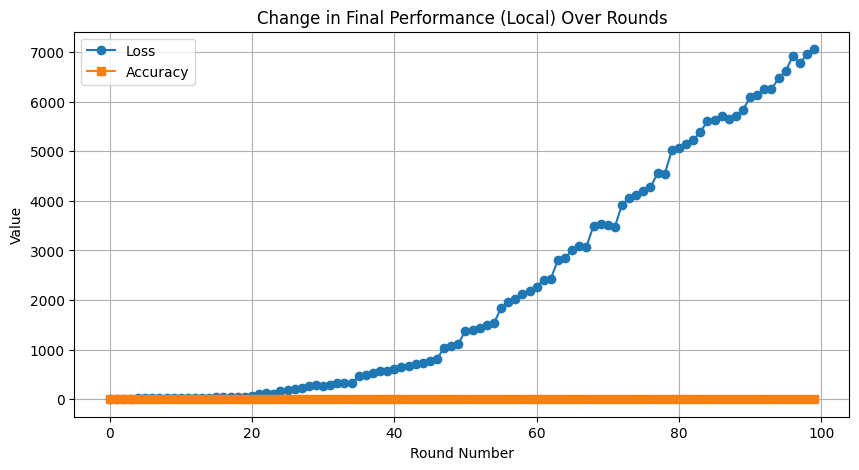

In [1]:
import collections
import json

import matplotlib.pyplot as plt

# Load JSON data
with open("results_visual/n_seller_10_n_adv_1_strength_1.0/market_log.json", "r") as f:
    data = json.load(f)

# Track seller selection counts
seller_selection_counts = collections.Counter()

# Track final performance changes
round_numbers = []
final_loss = []
final_acc = []

# Process each round
for round_data in data:
    round_numbers.append(round_data["round_number"])
    final_loss.append(round_data["final_perf_local"]["loss"])
    final_acc.append(round_data["final_perf_local"]["acc"])

    # Count selections per seller
    for seller in round_data["used_sellers"]:
        seller_selection_counts[seller] += 1

# Plot seller selection counts
plt.figure(figsize=(10, 5))
plt.bar(seller_selection_counts.keys(), seller_selection_counts.values(), color="skyblue")
plt.xlabel("Seller ID")
plt.ylabel("Number of Selections")
plt.title("Number of Selections per Seller")
plt.xticks(rotation=45)
plt.show()

# Plot final loss and accuracy changes over rounds
plt.figure(figsize=(10, 5))
plt.plot(round_numbers, final_loss, label="Loss", marker="o")
plt.plot(round_numbers, final_acc, label="Accuracy", marker="s")
plt.xlabel("Round Number")
plt.ylabel("Value")
plt.title("Change in Final Performance (Local) Over Rounds")
plt.legend()
plt.grid()
plt.show()


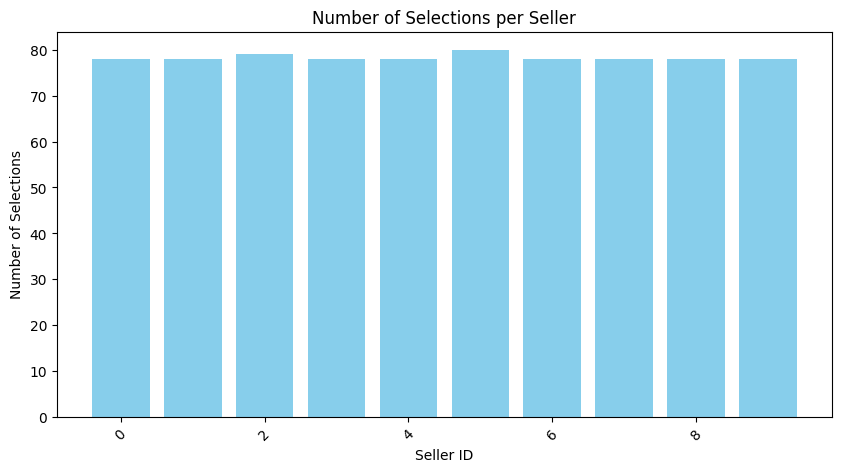

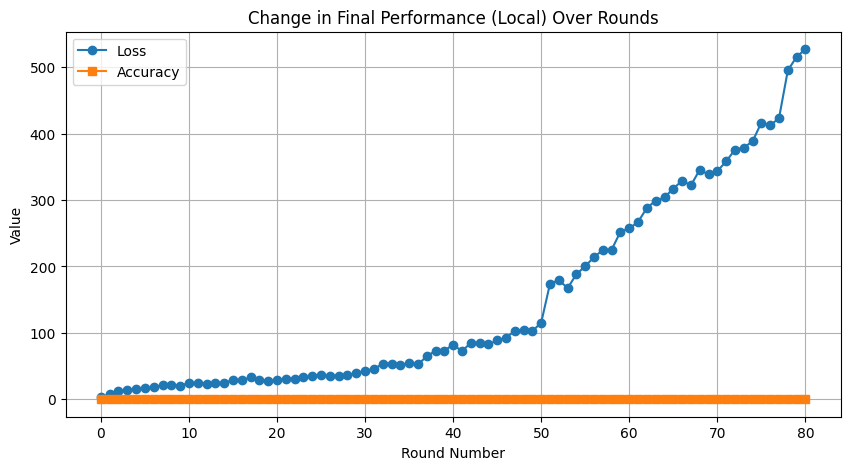

In [4]:
import torch
import matplotlib.pyplot as plt
import collections

# Load PyTorch checkpoint file
checkpoint = torch.load("results_visual/n_seller_10_n_adv_0_strength_1.0/market_log_round_80.ckpt", weights_only=False )  # Change filename as needed

# Ensure data follows the expected format
data = checkpoint  # Assuming it's directly stored in the checkpoint file

# Track seller selection counts
seller_selection_counts = collections.Counter()

# Track final performance changes
round_numbers = []
final_loss = []
final_acc = []

# Process each round
for round_data in data:
    round_numbers.append(round_data["round_number"])
    final_loss.append(round_data["final_perf_local"]["loss"])
    final_acc.append(round_data["final_perf_local"]["acc"])

    # Count selections per seller
    for seller in round_data["used_sellers"]:
        seller_selection_counts[seller] += 1

# Plot seller selection counts
plt.figure(figsize=(10, 5))
plt.bar(seller_selection_counts.keys(), seller_selection_counts.values(), color="skyblue")
plt.xlabel("Seller ID")
plt.ylabel("Number of Selections")
plt.title("Number of Selections per Seller")
plt.xticks(rotation=45)
plt.show()

# Plot final loss and accuracy changes over rounds
plt.figure(figsize=(10, 5))
plt.plot(round_numbers, final_loss, label="Loss", marker="o")
plt.plot(round_numbers, final_acc, label="Accuracy", marker="s")
plt.xlabel("Round Number")
plt.ylabel("Value")
plt.title("Change in Final Performance (Local) Over Rounds")
plt.legend()
plt.grid()
plt.show()
